In [1]:
import json
import os
import time
import warnings

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx
import pybedtools
import csv
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

from borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2024-10-06 18:03:39.445294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 18:03:39.445350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 18:03:39.446381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 18:03:39.453231: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 18:03:40.984763: W tensorflow/compiler/tf2

In [2]:
%%bash

#Download model weights (data fold 3, 4 replicates)
for rep in f3c0,f0 f3c1,f1 f3c2,f2 f3c3,f3; do IFS=","; set -- $rep; 
  mkdir -p "saved_models/$1/train"
  local_model="saved_models/$1/train/model0_best.h5"
  if [ -f "$local_model" ]; then
    echo "$1 model already exists."
  else
    wget --progress=bar:force "https://storage.googleapis.com/seqnn-share/borzoi/$2/model0_best.h5" -O "$local_model"
  fi
done

#Download and uncompress annotation files
mkdir -p hg38/genes/gencode41
mkdir -p hg38/genes/polyadb

if [ -f hg38/genes/gencode41/gencode41_basic_nort.gtf ]; then
  echo "Gene annotation already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_nort.gtf
fi

if [ -f hg38/genes/gencode41/gencode41_basic_nort_protein.gtf ]; then
  echo "Gene annotation (no read-through, protein-coding) already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort_protein.gtf.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_nort_protein.gtf
fi

if [ -f hg38/genes/gencode41/gencode41_basic_protein.gtf ]; then
  echo "Gene annotation (protein-coding) already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein.gtf.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_protein.gtf
fi

if [ -f hg38/genes/gencode41/gencode41_basic_tss2.bed ]; then
  echo "TSS annotation already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_tss2.bed.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_tss2.bed
fi

if [ -f hg38/genes/gencode41/gencode41_basic_protein_splice.csv.gz ]; then
  echo "Splice site annotation already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz -O hg38/genes/gencode41/gencode41_basic_protein_splice.csv.gz
fi

if [ -f hg38/genes/gencode41/gencode41_basic_protein_splice.gff ]; then
  echo "Splice site annotation already exist."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.gff.gz | gunzip -c > hg38/genes/gencode41/gencode41_basic_protein_splice.gff
fi

if [ -f hg38/genes/polyadb/polyadb_human_v3.csv.gz ]; then
  echo "PolyA site annotation already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz -O hg38/genes/polyadb/polyadb_human_v3.csv.gz
fi

#Download and index hg38 genome
mkdir -p hg38/assembly/ucsc

if [ -f hg38/assembly/ucsc/hg38.fa ]; then
  echo "Human genome FASTA already exists."
else
  wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38/assembly/ucsc/hg38.fa
fi


f3c0 model already exists.
f3c1 model already exists.
f3c2 model already exists.
f3c3 model already exists.
Gene annotation already exists.
Gene annotation (no read-through, protein-coding) already exists.
Gene annotation (protein-coding) already exists.
TSS annotation already exists.
Splice site annotation already exist.
Splice site annotation already exist.
PolyA site annotation already exist.
Human genome FASTA already exists.


In [3]:
pyfaidx.Faidx('hg38/assembly/ucsc/hg38.fa')

Faidx("hg38/assembly/ucsc/hg38.fa")

In [4]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_reps = 1       #To use only one model replicate, set to 'n_reps = 1'. To use all four replicates, set 'n_reps = 4'.
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Remove cropping
params_model['trunk'][-2]['cropping'] = 0

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for rep_ix in range(n_reps) :
    
    model_file = "saved_models/f3c" + str(rep_ix) + "/train/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    
    models.append(seqnn_model)


2024-10-06 18:05:25.100489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


In [5]:
#Load genome fasta and gene annotations

#Initialize fasta sequence extractor
fasta_open = pysam.Fastafile('hg38/assembly/ucsc/hg38.fa')

#Load gene/exon annotation
gtf_file = 'hg38/genes/gencode41/gencode41_basic_nort_protein.gtf'

transcriptome = bgene.Transcriptome(gtf_file)

#Get gene span bedtool
bedt_span = transcriptome.bedtool_span()

#Load APA atlas
apa_df = pd.read_csv('hg38/genes/polyadb/polyadb_human_v3.csv.gz', sep='\t', compression='gzip')
apa_df = apa_df[['pas_id', 'gene', 'chrom', 'position_hg38', 'strand', 'site_num', 'num_sites', 'site_type', 'pas_type', 'total_count']]

apa_df.loc[apa_df['pas_type'] == 'NoPAS', 'pas_type'] = 'No_CSE'

#Only consider 3' UTR sites
apa_df_utr = apa_df.query("site_type == '3\\' most exon'").copy().reset_index(drop=True)

#Or intronic sites
apa_df_intron = apa_df.query("site_type == 'Intron' and pas_type != 'No_CSE'").copy().reset_index(drop=True)

print("len(apa_df_utr) = " + str(len(apa_df_utr)))
print("len(apa_df_intron) = " + str(len(apa_df_intron)))

#Load TSS atlas
tss_df = pd.read_csv('hg38/genes/gencode41/gencode41_basic_tss2.bed', sep='\t', names=['chrom', 'position_hg38', 'end', 'tss_id', 'feat1', 'strand'])
tss_df['gene'] = tss_df['tss_id'].apply(lambda x: x.split("/")[1] if "/" in x else x)

print("len(tss_df) = " + str(len(tss_df)))


len(apa_df_utr) = 114605
len(apa_df_intron) = 83473
len(tss_df) = 116649


In [6]:
#Get reference/alternate sequence for variant, and annotations for target gene

search_gene = 'ENSG00000077522'

center_pos = 236763042

chrom = 'chr1'
poses = [236763042]
alts = ['G']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

load_isoforms = True

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

gene = transcriptome.genes[gene_keys[0]]
gene_strand = gene.strand

if chrom is None or start is None or end is None :
    chrom = gene.chrom
    g_start, g_end = gene.span()
    mid = (g_start + g_end) // 2
    start = mid - seq_len // 2
    end = mid + seq_len // 2

#Determine output sequence start
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True)

#Get sequence bedtool
seq_bedt = pybedtools.BedTool('%s %d %d' % (chrom, start, end), from_string=True)

#Get all genes (exons and strands) overlapping input window
gene_ids = sorted(list(set([overlap[3] for overlap in bedt_span.intersect(seq_bedt, wo=True) if search_gene not in overlap[3]])))
gene_slices = []
gene_strands = []
for gene_id in gene_ids :
    gene_slices.append(transcriptome.genes[gene_id].output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True))
    gene_strands.append(transcriptome.genes[gene_id].strand)

#Get 3' UTR pA sites for gene
apa_df_gene_utr = apa_df_utr.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]
apa_df_gene_intron = apa_df_intron.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

#Get TSS sites for gene
tss_df_gene = tss_df.loc[tss_df['gene'].str.contains(search_gene)].copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

def _switch_transcript_id(id_str) :
    return id_str.replace("gene_id", "gene_id_orig").replace("transcript_id", "gene_id")

#Get gene isoforms
isoform_slices = None
if load_isoforms :
    gtf_df = pd.read_csv(gtf_file, sep='\t', skiprows=5, names=['chrom', 'havana_str', 'feature', 'start', 'end', 'feat1', 'strand', 'feat2', 'id_str'])
    gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains(search_gene)].copy().reset_index(drop=True)
    gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains("transcript_id")].copy().reset_index(drop=True)
    gtf_df = gtf_df.loc[gtf_df['feature'] == 'exon'].copy().reset_index(drop=True)
    
    transcript_ids = gtf_df['id_str'].apply(lambda x: x.split("transcript_id \"")[1].split("\";")[0]).unique().tolist()
    gtf_df['id_str'] = gtf_df['id_str'].apply(_switch_transcript_id)
    
    gtf_df.to_csv('borzoi_gene_isoforms.gtf', sep='\t', index=False, header=False, quoting=csv.QUOTE_NONE)
    
    transcriptome_iso = bgene.Transcriptome('borzoi_gene_isoforms.gtf')
    
    isoform_slices = []
    for transcript_id in transcript_ids :
        isoform_slices.append(transcriptome_iso.genes[transcript_id].output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True))


2024-10-06 18:06:54.594911: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-10-06 18:06:54.664734: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-06 18:06:54.961769: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


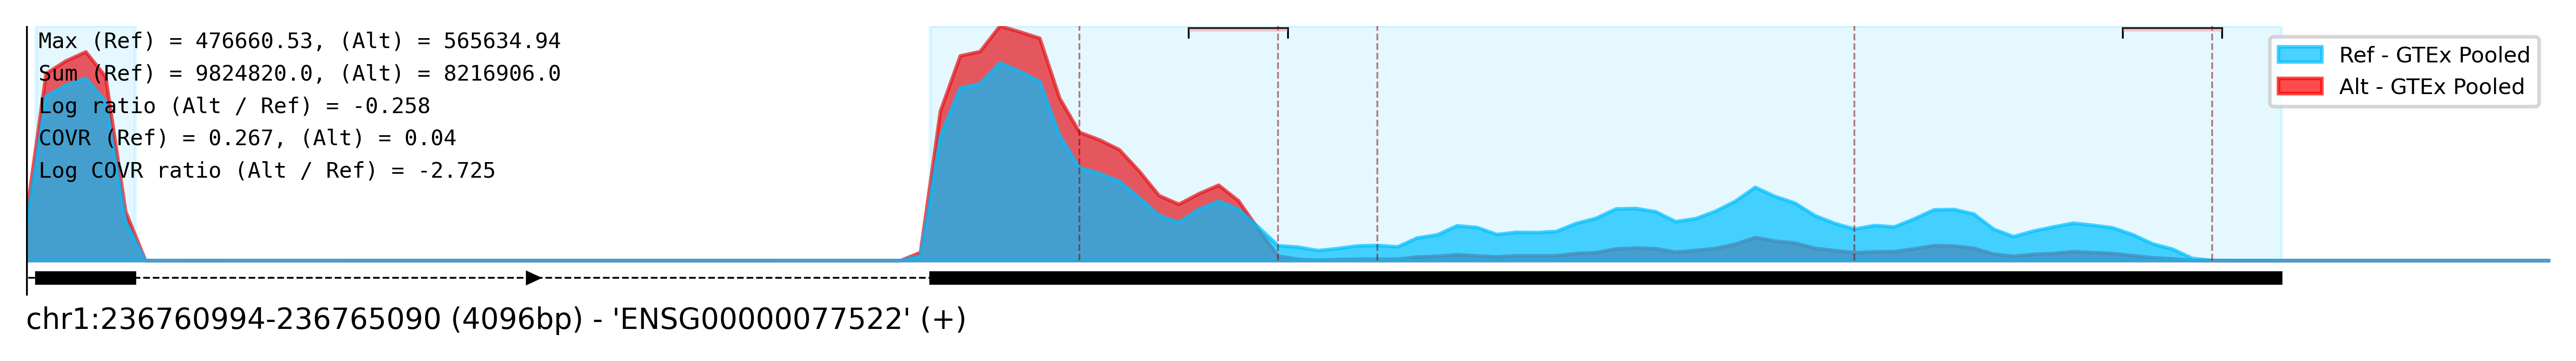

CPU times: user 17 s, sys: 284 ms, total: 17.3 s
Wall time: 20.1 s


In [7]:
%%time
#Predict for chr1_236763042_A_G
# (~6 minutes on CPU w 1 replicate; ~15 seconds on GPU)

save_figs = False
save_suffix = '_chr1_236763042_A_G'

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)


#Visualize coverage tracks
plot_start = seq_len // 2 - 4096 // 2
plot_end = seq_len // 2 + 4096 // 2
bin_size = 32
pad = 0

highlight_covr_poses_rel = [236763033 - start, 236764539 - start]
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 5

#Tracks
track_indices = [
    np.nonzero((targets_df['identifier'].str.contains('GTEX-') | targets_df['identifier'].str.contains('K-562')).values)[0].tolist(),
]

track_names = [
    'GTEx Pooled',
]

track_colors = [
    ['deepskyblue', 'red'],
]

track_labels = [
    ['Ref', 'Alt'],
]

track_scale = 0.01
track_transform = 3./4.
soft_clip = 384.

untransform_old = True

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=y_mut,
    plot_pair=True,
    pair_order=[1, 0],
    pair_alpha=0.7,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    bin_size=bin_size,
    pad=pad,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    gene_slices=gene_slices,
    isoform_slices=isoform_slices,
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=gene_strands,
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=False,
    annotate_tss=False,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1.5),
    untransform_old=untransform_old,
)


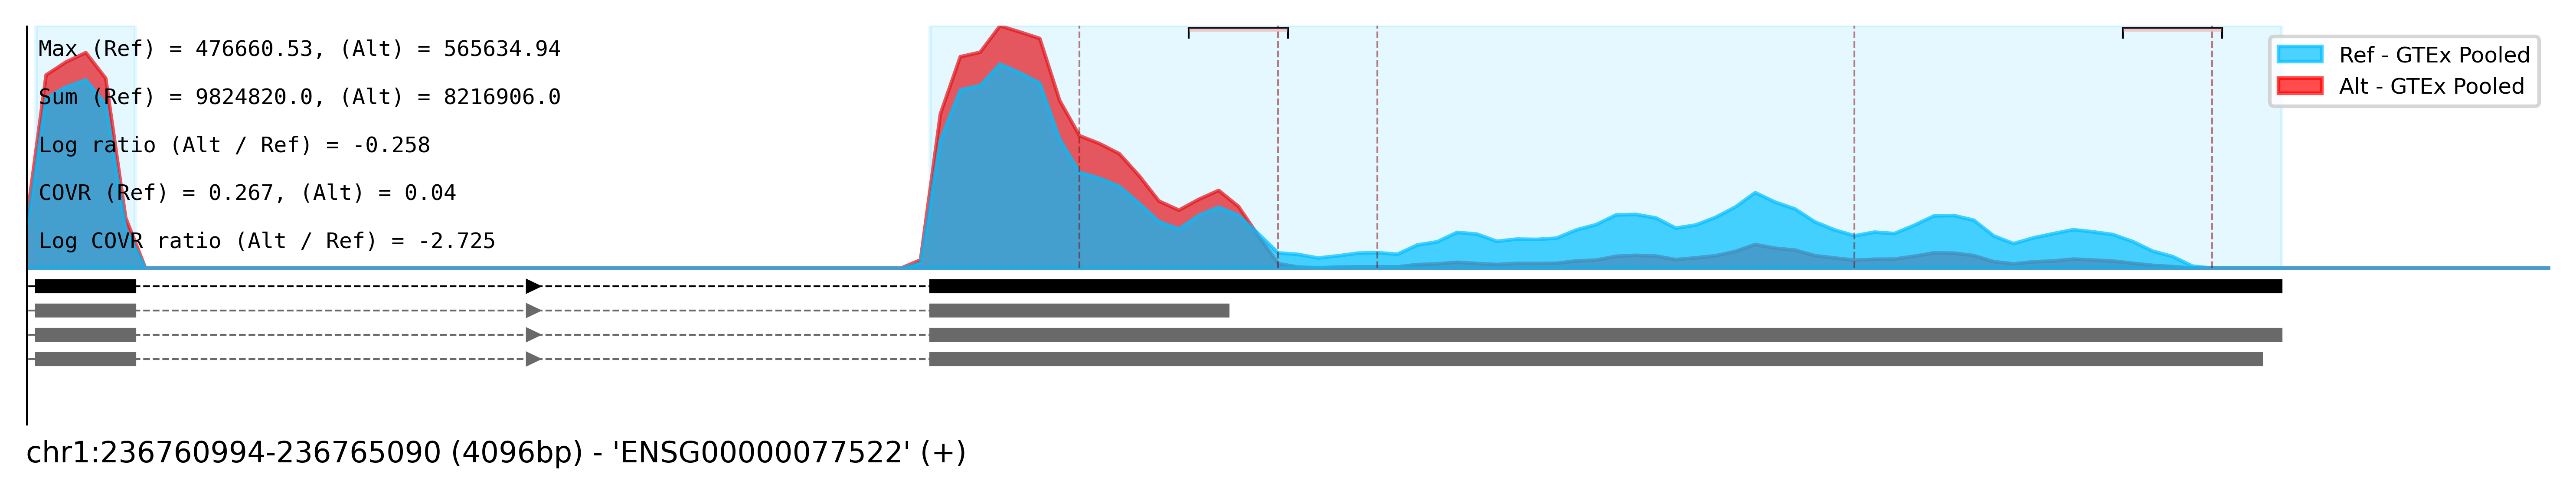

In [8]:
#Re-plot coverage tracks and annotate isoforms

plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=y_mut,
    plot_pair=True,
    pair_order=[1, 0],
    pair_alpha=0.7,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    bin_size=bin_size,
    pad=pad,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    gene_slices=gene_slices,
    isoform_slices=isoform_slices,
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=gene_strands,
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=False,
    annotate_tss=False,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=True,
    plot_isoform_strands=True,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.5,
    plot_as_bars=False,
    fig_size=(10, 2),
    untransform_old=untransform_old,
)


In [9]:
#Print polyA site bin positions and other info

plot_start = center_pos - 4096 // 2
plot_end = center_pos + 4096 // 2

plot_start_bin = (plot_start - start) // bin_size - pad
plot_end_bin = (plot_end - start) // bin_size - pad

mut_bin = (poses[0] - start) // bin_size - pad

#Get polyA site positions
pas_poses = apa_df.query("chrom == '" + chrom + "' and position_hg38 >= " + str(plot_start) + " and position_hg38 < " + str(plot_end))['position_hg38'].values.tolist()

print("mut_bin = " + str(mut_bin))
print("")

#Print polyA site positions
for pas_ix, pas_pos in enumerate(pas_poses) :
    
    pas_bin = int((pas_pos - start) // 32) - 16
    
    bin_end = pas_bin + 3
    bin_start = bin_end - 5
    
    print("pas_ix = " + str(pas_ix) + ": bin = " + str(pas_bin) + " (" + str(bin_start) + " - " + str(bin_end) + ")")


mut_bin = 8192

pas_ix = 0: bin = 8165 (8163 - 8168)
pas_ix = 1: bin = 8175 (8173 - 8178)
pas_ix = 2: bin = 8180 (8178 - 8183)
pas_ix = 3: bin = 8204 (8202 - 8207)
pas_ix = 4: bin = 8222 (8220 - 8225)


In [10]:
#Choose polyA sites to use for attributions

prox_pas_pos = pas_poses[1]

prox_pas_bin = 8175
dist_pas_bin = 8222


In [10]:
%%time
#Get contribution scores (gradient) for pooled GTEX tracks
# (~20 minutes on CPU; otherwise runnable only on 40GB GPU cards, e.g. A100)

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    dist_pas_bin-5,
    dist_pas_bin,
    prox_pas_bin-5,
    prox_pas_bin,
    target_index[np.arange(0, 89).tolist()].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    subtract_avg=True,
    fold_index=np.arange(n_reps).tolist(),
    untransform_old=True,
)


1/1 [==============================] - 220s 220s/step
CPU times: user 18min 49s, sys: 2min 44s, total: 21min 33s
Wall time: 22min 16s


--- WT ---


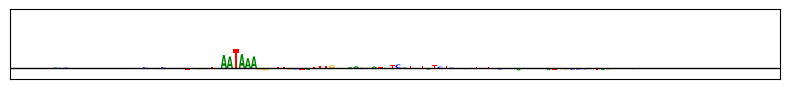

--- Mut ---


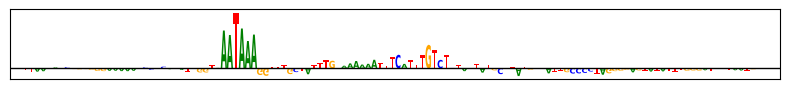

In [11]:
#Visualize gradient contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(prox_pas_pos - start) + 3 - 64,
    plot_end=(prox_pas_pos - start) + 3 + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex'
)


In [12]:
%%time
#Get contribution scores (ISM) for pooled GTEX tracks
# (not feasible to run on CPU; ~30 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (prox_pas_pos - start) + 3 - 64,
    (prox_pas_pos - start) + 3 + 64,
    dist_pas_bin-5,
    dist_pas_bin,
    prox_pas_bin-5,
    prox_pas_bin,
    np.arange(0, 89).tolist(),
    0.01,
    3./4.,
    384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    untransform_old=True,
)


example_ix = 0
example_ix = 1
CPU times: user 16min 8s, sys: 1min 21s, total: 17min 30s
Wall time: 33min 52s


--- WT ---


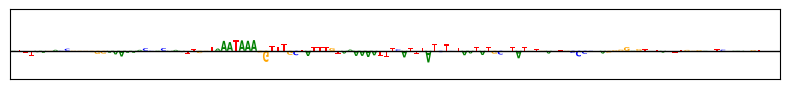

--- Mut ---


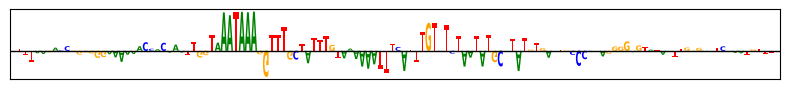

In [13]:
#Visualize ISM contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(prox_pas_pos - start) + 3 - 64,
    plot_end=(prox_pas_pos - start) + 3 + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex'
)


In [14]:
%%time
#Get contribution scores (ISM shuffle) for pooled GTEX tracks
# (not feasible to run on CPU; ~135 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (prox_pas_pos - start) + 3 - 64,
    (prox_pas_pos - start) + 3 + 64,
    dist_pas_bin-5,
    dist_pas_bin,
    prox_pas_bin-5,
    prox_pas_bin,
    np.arange(0, 89).tolist(),
    0.01,
    3./4.,
    384.,
    window_size=5,
    n_samples=12,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    untransform_old=True,
)


example_ix = 0
example_ix = 1
CPU times: user 1h 4min 15s, sys: 5min 30s, total: 1h 9min 46s
Wall time: 2h 15min 18s


--- WT ---


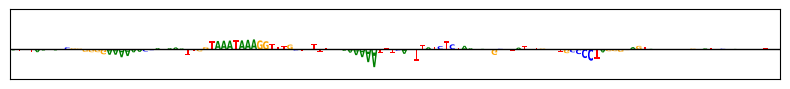

--- Mut ---


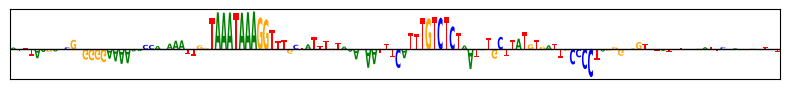

In [15]:
#Visualize ISM Shuffle contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(prox_pas_pos - start) + 3 - 64,
    plot_end=(prox_pas_pos - start) + 3 + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex'
)


In [11]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr1_236763042_A_G.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr1_236763042_A_G.txt", sep='\t', names=['file'])['file'].values.tolist()


gtex_targets_wt.shape = (16384, 6)
gtex_targets_mut.shape = (16384, 6)


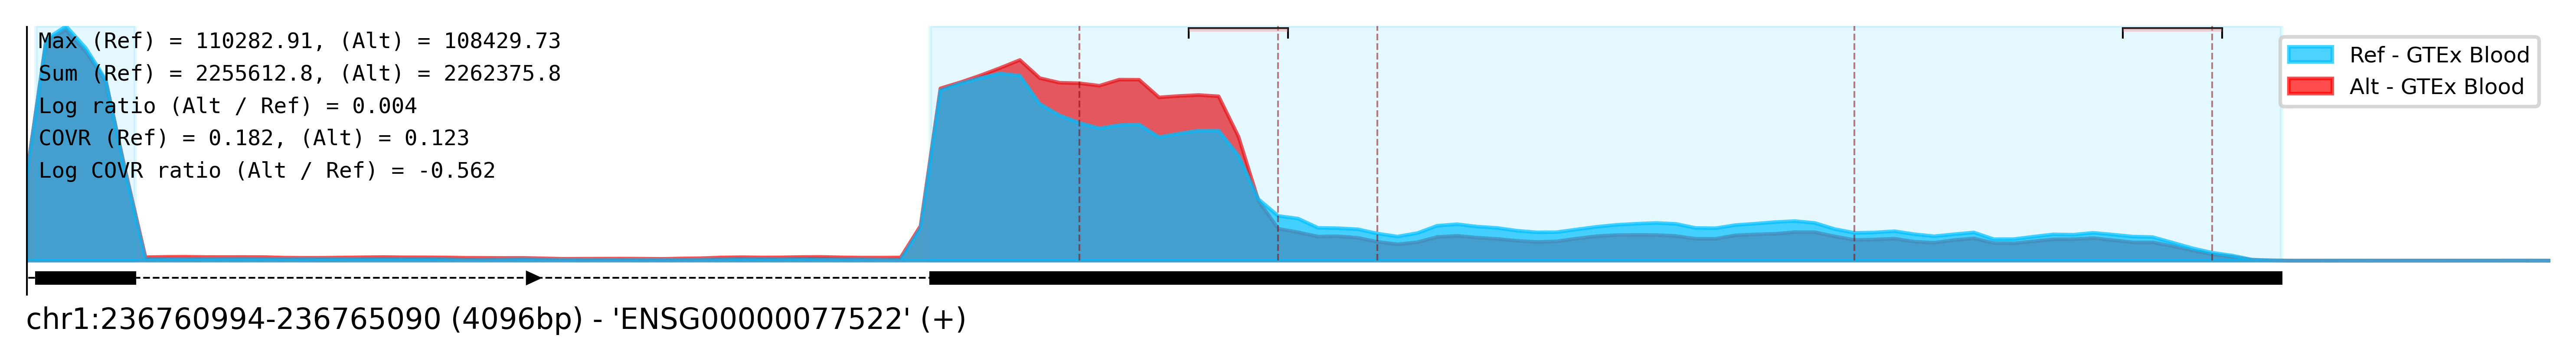

In [12]:
#Visualize measured coverage tracks for chr10_116952944_T_C

save_figs = False
save_suffix = '_chr1_236763042_A_G_meas_2_subjects'

center_pos = 236763042

chrom = 'chr1'
poses = [236763042]
alts = ['G']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 0, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 0, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01, transform_old=True)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01, transform_old=True)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

#Visualize coverage tracks
plot_start = seq_len // 2 - 4096 // 2
plot_end = seq_len // 2 + 4096 // 2
bin_size = 32
pad = 0

highlight_covr_poses_rel = [236763033 - start, 236764539 - start]
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 5

#Tracks
track_indices = [
    np.arange(gtex_targets_wt.shape[1], dtype='int32').tolist(),
]

track_names = [
    'GTEx Blood',
]

track_colors = [
    ['deepskyblue', 'red'],
]

track_labels = [
    ['Ref', 'Alt'],
]

track_scale = 0.01
track_transform = 3./4.
soft_clip = 384.

untransform_old = True

#Plot coverage
plot_coverage_tracks(
    gtex_targets_wt[None, None, ...],
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=gtex_targets_mut[None, None, ...],
    plot_pair=True,
    pair_order=[1, 0],
    pair_alpha=0.7,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    normalize_counts=True,
    normalize_start_rel=524288 // 2 - 2048 * 8,
    normalize_end_rel=524288 // 2 + 2048 * 8,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    bin_size=bin_size,
    pad=pad,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    gene_slices=gene_slices,
    isoform_slices=isoform_slices,
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=gene_strands,
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=False,
    annotate_tss=False,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1.5),
    untransform_old=untransform_old,
)
